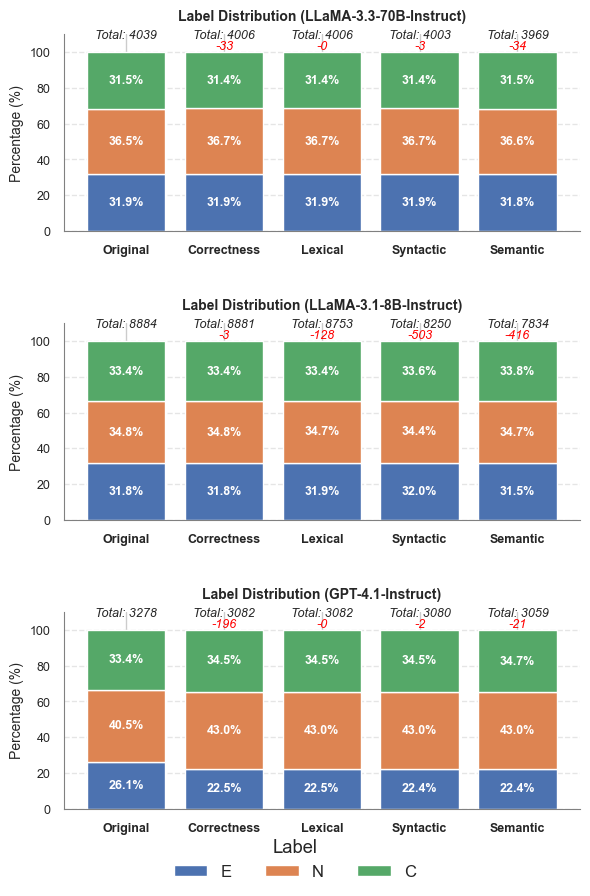

In [123]:
import matplotlib.pyplot as plt
import numpy as np

# 数据准备
labels = ["E", "N", "C"]
stages = ["Original", "Correctness", "Lexical", "Syntactic", "Semantic"]
colors = ["#4C72B0", "#DD8452", "#55A868"]
models = {
    "LLaMA-3.3-70B-Instruct": [[1289, 1476, 1274], [1278, 1469, 1259], [1278, 1469, 1259], [1278, 1469, 1256], [1263, 1454, 1252]],
    "LLaMA-3.1-8B-Instruct":  [[2823, 3092, 2969], [2821, 3091, 2969], [2795, 3033, 2925], [2641, 2841, 2768], [2470, 2716, 2648]],
    "GPT-4.1-Instruct":       [[857, 1326, 1095], [692, 1326, 1064], [692, 1326, 1064], [691, 1325, 1064], [685, 1314, 1060]]
}

# 创建3行1列的subplot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 9))
axes = axes.flatten()

for ax, (model_name, counts) in zip(axes, models.items()):
    arr = np.array(counts, dtype=float)
    sums = arr.sum(axis=1)
    percentages = arr / sums[:, None] * 100
    bottom = np.zeros(len(stages))

    for i, (label, color) in enumerate(zip(labels, colors)):
        bars = ax.bar(stages, percentages[:, i], label=label, bottom=bottom, color=color, edgecolor='white', linewidth=1)
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + height / 2,
                    f"{height:.1f}%",
                    ha='center', va='center',
                    color='white' if height > 15 else 'black',
                    fontsize=9, weight='bold')
        bottom += percentages[:, i]

    # 加上总数提示
    for j, total in enumerate(sums):
        ax.text(j, 106, f"Total: {int(total)}", ha='center', va='bottom', fontsize=9, style='italic')
    for j in range(1, len(sums)):
        delta = int(sums[j - 1] - sums[j])
        ax.text(j, 100, f"-{delta}", ha='center', va='bottom', fontsize=9, color='red', style='italic')


    ax.set_title(f"Label Distribution ({model_name})", weight='bold', pad=10, fontsize = 10)
    ax.set_ylabel("Percentage (%)", fontsize=10)
    ax.set_ylim(0, 110)
    ax.set_xticks(np.arange(len(stages)))
    ax.set_xticklabels(stages, fontweight='bold')
    ax.tick_params(axis='both', labelsize=9)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.spines[['top', 'right']].set_visible(False)

# 图例在底部
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Label", loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, 0))

plt.tight_layout(h_pad=3.0, rect=[0, 0.05, 1, 1])
plt.savefig("/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/label_distribution.pdf", bbox_inches="tight", dpi=300)
plt.show()


In [2]:
## 给chaosnli的数设threshold
import json

def process_label_distribution(label_probs, threshold=0.3):
    # 找出哪些标签满足大于等于 threshold
    valid_indices = [i for i, p in enumerate(label_probs) if p >= threshold]
    count = len(valid_indices)
    if count == 0:
        return [0.0, 0.0, 0.0]
    # 每个有效标签分得 1/count，总和为 1.0
    return [1.0 / count if i in valid_indices else 0.0 for i in range(3)]

input_file = '/Users/phoebeeeee/ongoing/Beyond-noise/dataset/dev_cleaned.json'
output_file = '/Users/phoebeeeee/ongoing/Beyond-noise/dataset/dev_cleaned_30.json'

with open(input_file, 'r', encoding='utf-8') as fin, open(output_file, 'w', encoding='utf-8') as fout:
    for line in fin:
        item = json.loads(line)
        raw_label = item['label']
        new_label = process_label_distribution(raw_label)
        item['label'] = new_label
        fout.write(json.dumps(item, ensure_ascii=False) + '\n')


{"id": "23751e", "context": "Part of the reason for the difference in pieces per possible delivery may be due to the fact that five percent of possible residential deliveries are businesses, and it is thought, but not known, that a lesser percentage of possible deliveries on rural routes are businesses.", "statement": "It is thought, but not known, that a lesser percentage of possible deliveries on rural routes are businesses, and part of the reason for the difference in pieces per possible delivery, may be due to the fact that five percent of possible residential deliveries are businesses.", "label_count_round_1": {"contradiction": 1.0, "entailment": 1.0, "neutral": null}, "label_count_round_2": {"contradiction": 1.0, "entailment": 1.0, "neutral": null}, "label_set_round_1": ["contradiction", "entailment"], "label_set_round_2": ["contradiction", "entailment"], "error_labels": [], "has_ambiguity": true, "chaosnli_labels": {"e": 85, "n": 13, "c": 2}, "error_70b": [], "not_validated_exp_70b": {"c": 3}, "label_set_70b": ["contradiction", "entailment"]}


In [ ]:
# eval main

import json
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from sklearn.metrics import average_precision_score, precision_score, recall_score

VARIERR_PATH = Path("/Users/phoebeeeee/ongoing/Beyond-noise/dataset/varierr.json")
SCORE_PATH = Path("/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/gpt-4.1/scores_avg.json")

def recall_at_k(y_true, y_score, k):
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    idx = np.argsort(y_score)[::-1][:k]
    y_pred = np.zeros_like(y_true)
    y_pred[idx] = 1
    return recall_score(y_true, y_pred)

def precision_at_k(y_true, y_score, k):
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    idx = np.argsort(y_score)[::-1][:k]
    return precision_score(y_true[idx], np.ones(k))

def compute_metrics(id_to_score, id_to_gt):
    ids = [i for i in id_to_gt if i in id_to_score]
    y_true = np.array([id_to_gt[i] for i in ids])
    y_score = np.array([id_to_score[i] for i in ids])
    # print("y_true:", y_true)
    # print("y_score:", y_score)
    return {
        "ap": average_precision_score(y_true, y_score),
        # "p@50": precision_at_k(y_true, y_score, 50),
        "p@100": precision_at_k(y_true, y_score, 100),
        "r@100": recall_at_k(y_true, y_score, 100)
    }

def prettify_results(df: pd.DataFrame) -> str:
    df *= 100
    header = "Method\tAP\tP@100\tR@100"
    row = df.round(1).iloc[0]
    values = "\t".join([f"${v:.1f}$" for v in row])
    return f"{header}\n{df.index[0]}\t{values}"

def get_ground_truth(instances, strategy="label_correction", rerank_single_label=False):
    id_to_gt = {}
    for ex in instances:
        id_ = ex["id"]
        round1 = ex.get("label_count_round_1", {})
        errors = ex.get("error_labels", [])
        label_set_round_2 = ex.get("label_set_round_2", [])

        for label, count in round1.items():
            if count is None or (rerank_single_label and count > 1):
                continue
            label_id = f"{id_}-{label[0]}"
            if strategy == "label_correction":
                id_to_gt[label_id] = label in errors
            elif strategy == "ambiguous":
                id_to_gt[label_id] = (len(label_set_round_2) > 1) and (label in label_set_round_2)
            elif strategy == "label_correction_or_ambiguous":
                label_correction = label in errors
                ambiguous = (len(label_set_round_2) > 1) and (label in label_set_round_2)
                id_to_gt[label_id] = label_correction or ambiguous
    return id_to_gt

def build_score_table(varierr_path, score_path, strategy="label_correction", rerank_single_label=False):
    with open(varierr_path) as f:
        data = [json.loads(line) for line in f]

    with open(score_path) as f:
        id_to_score = json.load(f)

    id_to_gt = get_ground_truth(data, strategy=strategy, rerank_single_label=rerank_single_label)
    print(id_to_gt)
    id_to_score = {k: v for k, v in id_to_score.items() if k in id_to_gt}
    print(id_to_score)

    metrics = compute_metrics(id_to_score, id_to_gt)

    df = pd.DataFrame([metrics], index=[score_path.stem])
    return prettify_results(df)

print(build_score_table(
    varierr_path=VARIERR_PATH,
    score_path=SCORE_PATH,
    strategy="label_correction"
))


{'23751e-c': False, '23751e-e': False, '61429c-n': False, '54811c-c': True, '54811c-n': False, '12601n-n': False, '38477c-c': False, '1735n-c': False, '1735n-n': True, '7449e-e': True, '7449e-n': False, '24385e-n': False, '49807n-e': False, '49807n-n': False, '138448c-c': False, '138448c-n': False, '48454c-c': True, '48454c-n': False, '73260n-c': False, '73260n-e': True, '73260n-n': False, '76219n-e': False, '76219n-n': False, '10229n-n': False, '99791n-e': False, '99791n-n': False, '13964e-e': False, '13964e-n': False, '66185c-c': True, '66185c-e': False, '66185c-n': False, '65066n-n': False, '76020e-c': False, '76020e-e': False, '83248c-c': False, '83248c-n': True, '79141n-e': False, '79141n-n': False, '97926n-e': False, '97926n-n': False, '45957e-c': False, '45957e-n': False, '24126n-e': True, '24126n-n': False, '135251n-e': False, '135251n-n': False, '48223n-c': False, '48223n-e': False, '73518n-c': False, '73518n-n': False, '16996e-c': True, '16996e-n': False, '69815n-n': False, '

In [30]:
import json

# 文件路径
varierr_file = '/Users/phoebeeeee/ongoing/Beyond-noise/dataset/varierr.json'
model_file = '/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/llama33_70b_explanation_with_validation_count.jsonl'
output_file = '/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/varierr_without_70b.json'

# 加载 varierr 文件
with open(varierr_file, 'r', encoding='utf-8') as f:
    varierr_data = {json.loads(line)['id']: json.loads(line) for line in f}

# 加载模型生成文件
with open(model_file, 'r', encoding='utf-8') as f:
    model_data = {json.loads(line)['id']: json.loads(line) for line in f}
label_map = {'e': 'entailment', 'n': 'neutral', 'c': 'contradiction'}

merged = []

for uid, var_entry in varierr_data.items():
    # 获取模型生成对应条目
    model_entry = model_data.get(uid, {})

    # 删除 generated_explanations
    var_entry.pop('entailment', None)
    var_entry.pop('contradiction', None)
    var_entry.pop('neutral', None)
    var_entry.pop('idk', None)

    # 添加 error 和 not_validated_exp 字段（如果模型结果中有）
    if 'error' in model_entry:
        error_raw = model_entry['error']
        error_mapped = [label_map.get(lbl, lbl) for lbl in error_raw]
        var_entry['error_llm'] = error_mapped
    if 'not_validated_exp' in model_entry:
        var_entry['not_validated_exp_llm'] = model_entry['not_validated_exp']

    # 构造 label_set_70b：从 label_set_round_1 减去 error_70b
    original_labels = set(var_entry.get('label_set_round_1', []))
    error_labels = set(var_entry.get('error_llm', []))
    label_set_llm = sorted(original_labels - error_labels)

    var_entry['label_set_llm'] = label_set_llm

    merged.append(var_entry)

# 保存合并后的数据
with open(output_file, 'w', encoding='utf-8') as out:
    for item in merged:
        json.dump(item, out, ensure_ascii=False)
        out.write('\n')

print(f"✅ Merged file written to {output_file}")


✅ Merged file written to /Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/varierr_without_70b.json


In [31]:
import json
from collections import Counter

input_path = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/varierr_without_70b.json"
output_path = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/varierr_without_70b_dist.json"

def convert_label_list_to_dist(label_list):
    counter = Counter(label_list or [])
    e = counter.get("entailment", 0)
    n = counter.get("neutral", 0)
    c = counter.get("contradiction", 0)

    total = e + n + c
    if total == 0:
        return [0.0, 0.0, 0.0]
    return [e / total, n / total, c / total]  # 顺序为 [e, n, c]

with open(input_path, "r", encoding="utf-8") as infile, \
     open(output_path, "w", encoding="utf-8") as outfile:

    for line in infile:
        item = json.loads(line)

        label_list = item.get("label_set_llm")
        if label_list:
            item["label"] = convert_label_list_to_dist(label_list)
        else:
            item["label"] = [0.0, 0.0, 0.0]

        json.dump(item, outfile)
        outfile.write("\n")

print(f"处理完成，已写入新文件：{output_path}")


处理完成，已写入新文件：/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/varierr_without_70b_dist.json


In [32]:
## clean

import json
from pathlib import Path
from tqdm import tqdm

def normalize_label_dist(chaos_dict):
    # 标签顺序固定：["entailment", "neutral", "contradiction"]
    label_order = ["entailment", "neutral", "contradiction"]
    values = [(chaos_dict.get(k) or 0.0) for k in label_order]  # 将 None 转换为 0.0
    total = sum(values)
    if total == 0:
        return [0.0] * 3
    return [v / total for v in values]


def process_file(input_path, output_path):
    with open(input_path, "r", encoding="utf-8") as fin, open(output_path, "w", encoding="utf-8") as fout:
        for line in tqdm(fin, desc=f"Processing {input_path}"):
            raw = json.loads(line)
            out = {
                "uid": raw.get("id", raw.get("uid")),
                "premise": raw.get("context"),
                "hypothesis": raw.get("statement"),
                "label": raw.get("label")
            }
            fout.write(json.dumps(out, ensure_ascii=False) + "\n")

# 示例调用方式
if __name__ == "__main__":
    input_path = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/varierr_without_70b_dist.json"
    output_path = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/varierr_without_70b_cleaned.json"
    process_file(input_path, output_path)


Processing /Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/varierr_without_70b_dist.json: 500it [00:00, 64631.16it/s]


In [13]:
import json

file_path = '/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/varierr_without_70b.json'

mismatch_count = 0
total = 0

print("🔍 Entries with non-empty error_8b and label set differences:\n")

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line)
        total += 1

        labels_r1 = set(data.get("label_set_round_1", []))
        labels_70b = set(data.get("label_set_llm", []))
        errors = data.get("error_8b", [])

        # 打印 error_70b 非空的例子
        if errors:
            print(f"ID: {data['id']}")
            print(f"  label_set_round_1: {labels_r1}")
            print(f"  error_8b: {errors}")
            print(f"  label_set_llm: {labels_70b}")
            print()

        # 检查是否一致
        if labels_r1 != labels_70b:
            mismatch_count += 1

print(f"✅ Checked {total} entries.")
print(f"⚠️  Number of mismatches between label_set_round_1 and label_set_llm: {mismatch_count}")


🔍 Entries with non-empty error_8b and label set differences:

✅ Checked 500 entries.
⚠️  Number of mismatches between label_set_round_1 and label_set_llm: 0


In [44]:
import json

# 替换成你的 JSONL 文件路径
json_file = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/varierr_with_70b_cleaned.json"

with open(json_file, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        try:
            data = json.loads(line)
            label = data.get("label", None)
            if not isinstance(label, list):
                print(f"[Line {i+1}] ❌ uid: {data.get('id', 'N/A')} | label: {label} | type: {type(label)}")
        except json.JSONDecodeError as e:
            print(f"[Line {i+1}] 🚨 JSON decode error: {e}")


[Line 38] ❌ uid: N/A | label: None | type: <class 'NoneType'>
[Line 236] ❌ uid: N/A | label: None | type: <class 'NoneType'>
[Line 435] ❌ uid: N/A | label: None | type: <class 'NoneType'>
